***
***

# **COVID-19 Vaccination Progress**

## *8) FB Prophet (Daily Vaccinations)*

***
***

## Table of Contents

| 1. INTRODUCTION | 2. Visualisations | 3. SUMMARY |
|----|----|----|
| *1.1 Dataset Characteristics* | *2.1 Importing Libraries and Data* | 3.1 Key Findings |
| | *2.2 FB Prophet Model (univariate)* | 3.2 Next Steps |
| | *2.2 FB Prophet Model (additional regressors)* | |

***
***

## 1. INTRODUCTION

In this notebook we use the time series datasets (original and detrended) generated in notebook 6 (Feature Selection for Prediction and Time Series Specific EDA) in a FBProphet model, a modular regression model with interpretable parameters. It consists of linear regularised regression (L1 and L2 regularisation) as well as periodic components and fits them with sine and cosine waves.
***

### 1.1 Dataset Characteristics

1) Our 3 timeseries (Worldwide, Germany & Israel) contain the following detrended feature:

| FEATURE | description | comment |
|----|----|----|
| **date** | data entry (13th December 2020 to 24th March 2021) | - |
| **daily_vaccinations_raw** | daily vaccinations as CHANGE COMPARED TO PREVIOUS DAY | calculation: total_vaccinations |
***
***

## 2. IMPORTS AND DATA PREPARATION

***

### 2.1 Importing Libraries and Data

+ Import numpy (linear algebra), pandas (data processing), visualisation libraries (matplotlib, seaborn, plotly), FB Prophet and metric calulations (sklearn).
+ Import datasets on COVID-19 vaccination progress from notebook 6.

In [1]:
#Import basic libraries
import numpy as np #linear algebra
import pandas as pd #data processing
import random

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#Facebook PROPHET
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric #cross-validation = future work
from prophet.diagnostics import cross_validation, performance_metrics #cross-validation = future work

#Import libraries for grid search an statistics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Suppress pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Plot settings
%matplotlib inline

In [2]:
#Import datasets
#Worldwide - daily vaccinations (raw)
df_wrld = pd.read_csv('data/df_wrld.csv', parse_dates=['date'])
df_wrld.sort_values('date', inplace=True)
df_wrld = df_wrld.set_index('date')
df_wrld.index.freq = 'd'

#Germany -  daily vaccinations (raw)
df_ger = pd.read_csv('data/df_ger.csv', parse_dates=['date'])
df_ger.sort_values('date', inplace=True)
df_ger = df_ger.set_index('date')

#Israel -  daily vaccinations (raw)
df_isr = pd.read_csv('data/df_isr.csv', parse_dates=['date'])
df_isr.sort_values('date', inplace=True)
df_isr = df_isr.set_index('date')

***

### 2.1 FB Prophet Model (univariate)

In this section we investigate FBProphet for 3 timeseries (daily_vaccinations_raw --- worldwide, Germany, Israel).

FBProphet uses a decomposable time series model with three main model components:

+ Trend
+ Seasonality
+ Holidays.


They are combined in the following equation:

+ y(t)= g(t) + s(t) + h(t) + εt
+ g(t): piecewise linear or logistic growth curve for modeling non-periodic changes
+ s(t): periodic changes (i.e. seasonality)
+ h(t): effects of holidays with irregular schedules
+ εt: error term accounts for any unusual changes not accommodated by the model


The most important hyperparameters are:

+ ***n_changepoints:*** The number of changes (in first 80% of the time series) in the data, detected automatically by Prophet
+ ***changepoint_prior_scale:*** Changepoint flexibility (high = more flexible and higher risk of overfitting)
+ ***seasonality_mode:*** Additive & multiplicative (custom seasonalities can also be added)
+ ***seasonality_prior_scale:*** in analogy to changepoint_prior_scale
+ ***holidays:*** And last, but not least holidays can be added to the model. These can be selected from predifined country-specific holidays or defined manually and added. In our case vaccination started just before Xmas and therefore proceeded over Xmas and New Year, but since this was at the very beginning the effects don't need to be accounted for, as most countries startet the vaccination process in the New Year. As we only have data for 3 months with no additional key holidays to account for we did not inlcude this parameter in our model for now. However, as the process continues it will be sensible to inlcude country specific holidays in our model.


We can also perform hyperparameter grid searches and cross validation. Here we opted for a hyperparameter grid search for the first (worldwide) model to get a feel for how much tuning the hyperparameters can inlfuence the outcome. We opted against cross validation for now, since we only have a short time series at this point in time and we will be able to also test on new future data. Therefore we use a 10 day test set for optimisation and plan to test our models on new (APRIL 2021) data afterwards.

#### **TASK 1**: Worldwide Daily Vaccinations (raw)

1) Split data into train and test

2) Run grid search to select hyperparameters

3) Train model with top hypermarameters and predict for next 10 days

4) Visualise results

5) Evaluation metrics


**KEY FINDINGS**

Having carried out a grid search to fine-tune the hyperparameters the FBProphet (MAPE 17%) model for worldwide daily vaccinations is more or less in-line with the Holt-Winters (MAPE 16%) model.  We will need to unvestigate this via a grid search for hyperparamaters and consider additional regressors.

In [3]:
#Split data into train and test set
df_train, df_test = df_wrld[:'2021-03-14'].reset_index(), df_wrld['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [4]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [5]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw': 'y'}, axis=1)

In [6]:
#Define parameter grid and check number of variations
params_grid = {'n_changepoints' : [2,5,10,15,20], #lower than default as short time series
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5], #to influence underfitting
               'seasonality_prior_scale': [10,20,30,40]} #to influence underfitting

grid = ParameterGrid(params_grid)

count = 0
for p in grid:
    count = count+1

print('Total no. of possible FBProphet models:',count)

Total no. of possible FBProphet models: 100


In [7]:
#Perform grid search across selected hyperparameters
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

for p in grid:
    test = pd.DataFrame()
    #print(p)
    random.seed(42)
    
    model = Prophet(growth='linear',
                    n_changepoints = p['n_changepoints'],
                    changepoint_range=0.95,
                    changepoint_prior_scale = p['changepoint_prior_scale'],
                    seasonality_mode = 'multiplicative',
                    seasonality_prior_scale=p['seasonality_prior_scale'],
                    interval_width=0.95,
                    yearly_seasonality = False,
                    weekly_seasonality=True,
                    daily_seasonality = False)
    
    model.fit(df_train_fbp)
    future = model.make_future_dataframe(periods=90, freq='D',include_history = False)
    forecast = model.predict(future)
    test=forecast[['ds','yhat']]
    
    MAPE = mean_absolute_percentage_error(df_train_fbp['y'],test['yhat'])
    #print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

In [8]:
#Take a look at the top 5 hyperparameter combinations
model_parameters.sort_values('MAPE', ascending=False).head()

MAPE                                         Parameters
94  388.781086  {'changepoint_prior_scale': 0.5, 'n_changepoin...
92  388.764646  {'changepoint_prior_scale': 0.5, 'n_changepoin...
95  388.755503  {'changepoint_prior_scale': 0.5, 'n_changepoin...
93  388.718352  {'changepoint_prior_scale': 0.5, 'n_changepoin...
97  388.420325  {'changepoint_prior_scale': 0.5, 'n_changepoin...

In [9]:
#View the parameters of the best performimg model
model_parameters.iloc[94,1]

{'changepoint_prior_scale': 0.5,
 'n_changepoints': 15,
 'seasonality_prior_scale': 30}

In [10]:
#Forecasting with FB Prophet using the best parameters from the grid search
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                n_changepoints=15,
                changepoint_range=0.95, #Set to 90% of training data as only few datapoints available
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                seasonality_prior_scale=30, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 10 days
future = model.make_future_dataframe(periods=10) # default frequency: daily
forecast = model.predict(future)

In [11]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y          yhat    yhat_lower    yhat_upper
ds                                                              
2021-03-15   8580569.0  6.194022e+06  5.298260e+06  7.156796e+06
2021-03-16   7697723.0  7.213694e+06  6.286387e+06  8.093609e+06
2021-03-17   8621796.0  9.234618e+06  8.347220e+06  1.009609e+07
2021-03-18   9232608.0  1.036020e+07  9.462592e+06  1.131962e+07
2021-03-19  10122329.0  1.101056e+07  1.008377e+07  1.185753e+07
2021-03-20   9375708.0  9.852604e+06  8.858492e+06  1.077135e+07
2021-03-21   5478997.0  5.480705e+06  4.556970e+06  6.415715e+06
2021-03-22  11297560.0  7.140662e+06  6.256570e+06  8.089864e+06
2021-03-23  12236425.0  8.292615e+06  7.284477e+06  9.249357e+06
2021-03-24   7826562.0  1.058691e+07  9.472504e+06  1.150199e+07

In [12]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

             y      yhat
y     1.000000  0.941278
yhat  0.941278  1.000000


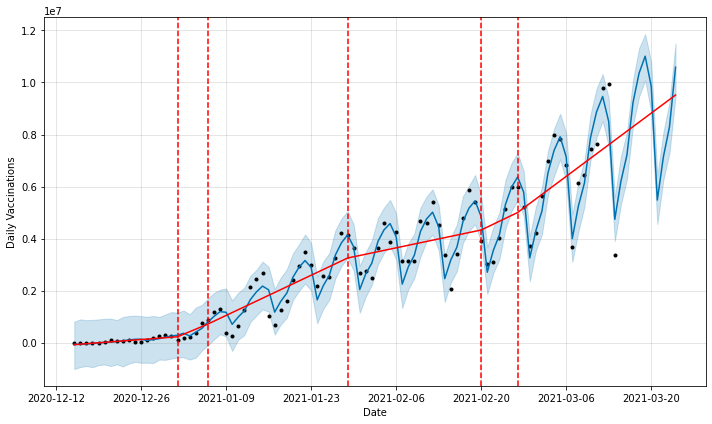

In [13]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

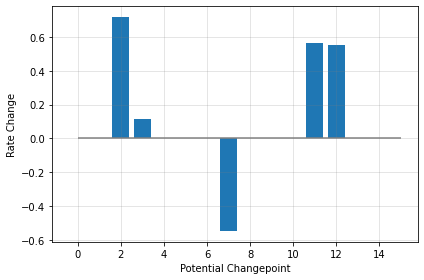

In [14]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

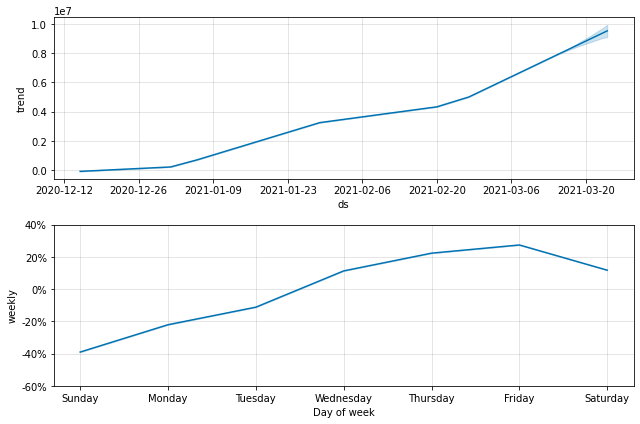

In [15]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

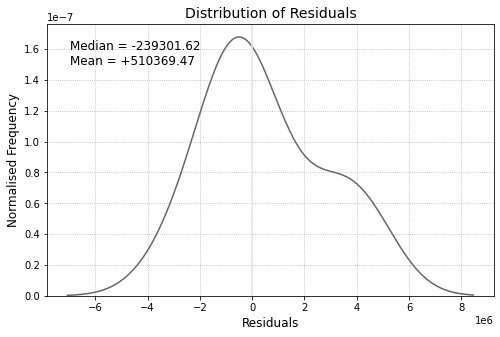

In [16]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

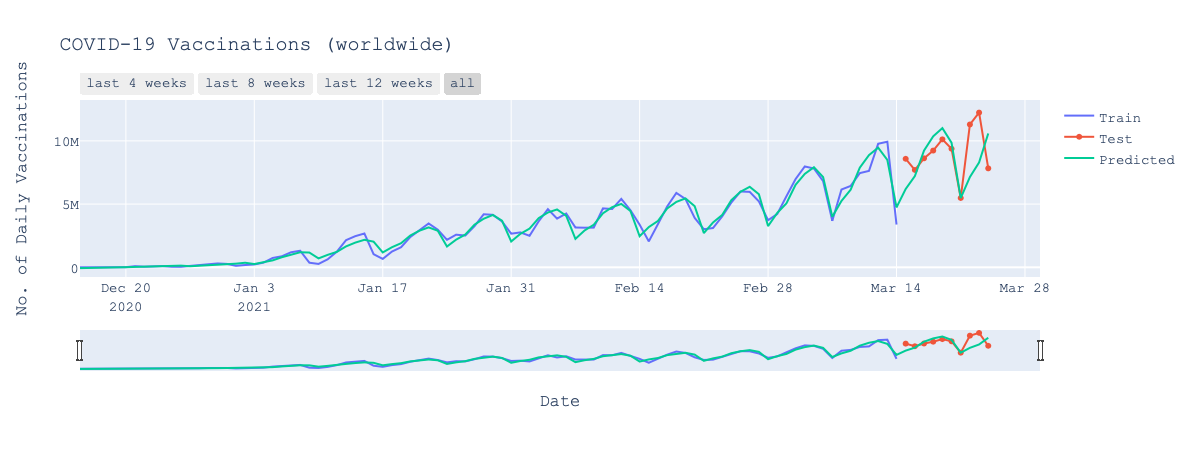

In [17]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (worldwide)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

![](./images/nb9_fig1.png)

In [18]:
#Evaluation metrics for FBProphet model
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the global FBProphet model are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the global FBProphet model are:
MAE score: 1683887.25
RMSE score: 2214638.16
MAPE score: 0.17


#### **TASK 2**: Daily Vaccinations (raw) (Germany)

1) Split data into train and test

2) Train model (with identical hyperparameters to the above model) and predict

3) Visualise results

4) Evaluation metrics


**KEY FINDINGS**

The FBProphet model for Germany captures the time series reasonably well, but fails with prediction to a greater extent as compared to the HW model, with a 43% MAPE for FBProphet, compared to 28% for HW. We will need to unvestigate this via a grid search for hyperparamaters and consider additional regressors.

In [19]:
#Split data into train and test set
df_train, df_test = df_ger[:'2021-03-14'].reset_index(), df_ger['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [20]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the end of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [21]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_germany': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_germany': 'y'}, axis=1)

In [22]:
#Forecasting with FB Prophet
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                n_changepoints=15,
                changepoint_range=0.95, #Set to 90% of training data as only few datapoints available
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                seasonality_prior_scale=30, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 9 days (as no data reported for 24th March at this point in time)
future = model.make_future_dataframe(periods=9) # default frequency: daily
forecast = model.predict(future)

In [23]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y           yhat     yhat_lower     yhat_upper
ds                                                               
2021-03-14  165580.0  164404.022717  149254.936835  179968.906327
2021-03-15  234063.0  276341.946577  260700.216317  293070.204097
2021-03-16  177909.0  304862.647526  288638.489386  319987.936728
2021-03-17  208570.0  344663.079640  328887.051357  361304.656603
2021-03-18  189173.0  336549.443631  320839.968903  353549.120252
2021-03-19  228125.0  353751.837944  337296.924871  370319.869613
2021-03-20  206690.0  270774.037887  253723.846875  286927.287035
2021-03-21  164604.0  191101.698118  174181.139102  207597.489361
2021-03-22  260116.0  320199.848982  301115.872308  338084.075736
2021-03-23  268295.0  352174.353014  332549.592678  373978.427185

In [24]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

             y      yhat
y     1.000000  0.903448
yhat  0.903448  1.000000


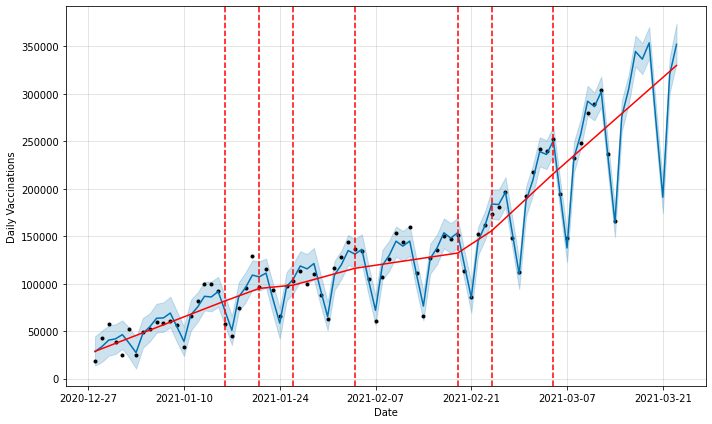

In [25]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

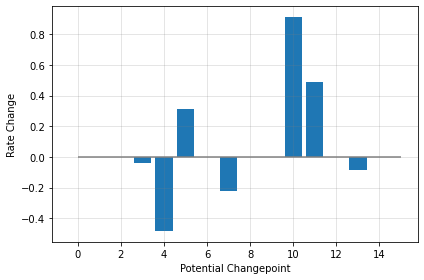

In [26]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

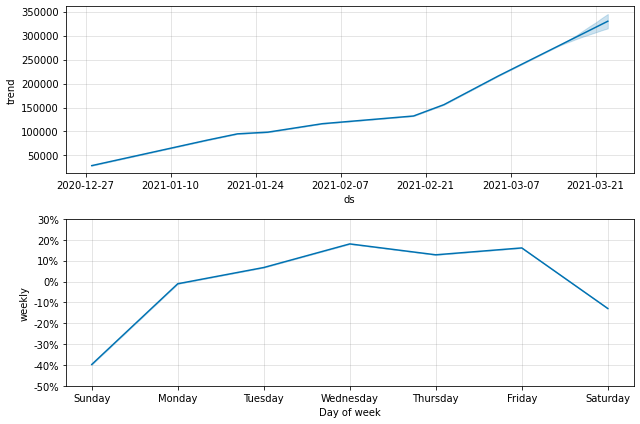

In [27]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

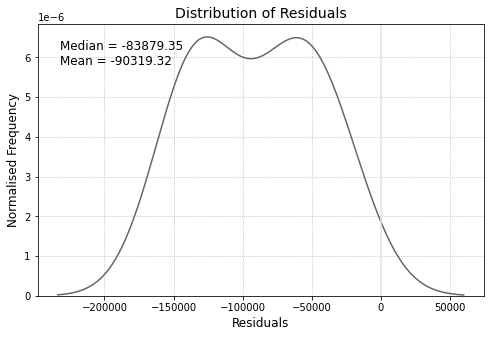

In [28]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

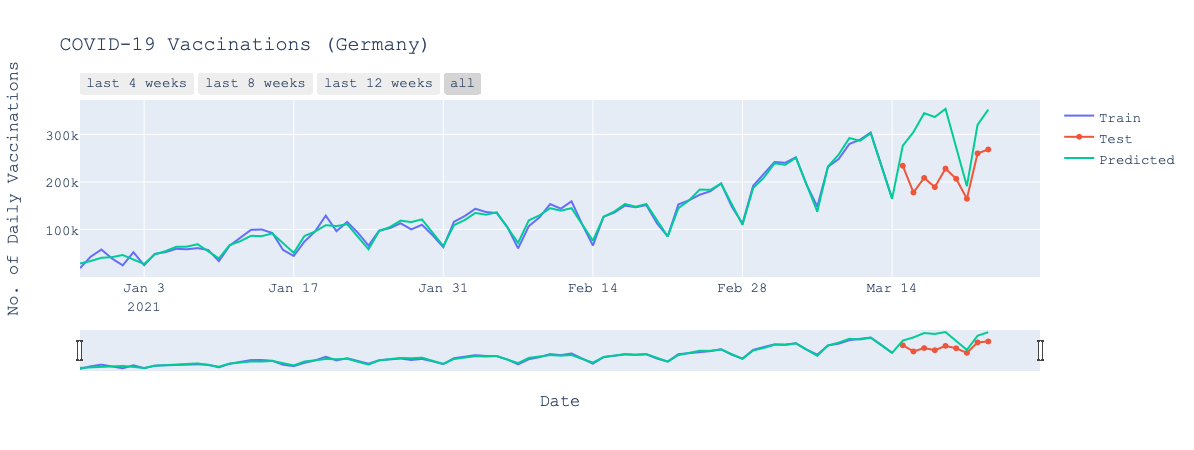

In [29]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (Germany)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

![](./images/nb9_fig2.png)

In [30]:
#Evaluation metrics for FBProphet model
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the FBProphet model for Israel are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the FBProphet model for Israel are:
MAE score: 90319.32
RMSE score: 99656.46
MAPE score: 0.43


#### **TASK 3**: Daily Vaccinations (raw) (Israel)

1) Split data into train and test

2) Train model (with identical hyperparameters to the above model) and predict

3) Visualise results

4) Evaluation metrics


**KEY FINDINGS**

The FBProphet model for Israel captures the time series reasonably well, but fails with prediction to a greater extent as compared to the HW model, with a 40% MAPE for FBProphet, compared to 14% for HW. We will need to unvestigate this via a grid search for hyperparamaters and consider additional regressors.

In [31]:
#Split data into train and test set
df_train, df_test = df_isr[:'2021-03-14'].reset_index(), df_isr['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(92, 2) (10, 2)


In [32]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Drop any rows that contain zeros or are empty at the beginning of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

#Drop any rows that contain zeros or are empty at the end of the series
df_train.replace([0], np.nan, inplace=True)
df_train.dropna(inplace=True)

In [33]:
#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for FBProphet
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)

In [34]:
#Forecasting with FB Prophet
#Define model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                n_changepoints=15,
                changepoint_range=0.95, #Set to 90% of training data as only few datapoints available
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                seasonality_prior_scale=30, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Fit model
model.fit(df_train_fbp)

#Prediction for the next 9 days (as no data reported for 24th March at this point in time)
future = model.make_future_dataframe(periods=9) # default frequency: daily
forecast = model.predict(future)

In [35]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y           yhat     yhat_lower     yhat_upper
ds                                                               
2021-03-14  282381.0  220373.569490  124386.323399  307958.050644
2021-03-15  440051.0  257346.283624  163096.152375  357999.870735
2021-03-16  529119.0  321151.914377  225900.789323  422906.922465
2021-03-17  581855.0  382449.916759  287387.778030  479679.361437
2021-03-18  660276.0  418808.806696  323961.615258  516393.251244
2021-03-19  740655.0  447619.109547  353247.654776  540794.301248
2021-03-20  844285.0  448229.517397  348317.457667  546901.158266
2021-03-21  419618.0  217239.531107  125130.727593  309393.473057
2021-03-22  412197.0  253678.987890  158178.296160  346653.551990
2021-03-23  494805.0  316566.024992  221857.880862  411162.410975

In [36]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

           y    yhat
y     1.0000  0.6633
yhat  0.6633  1.0000


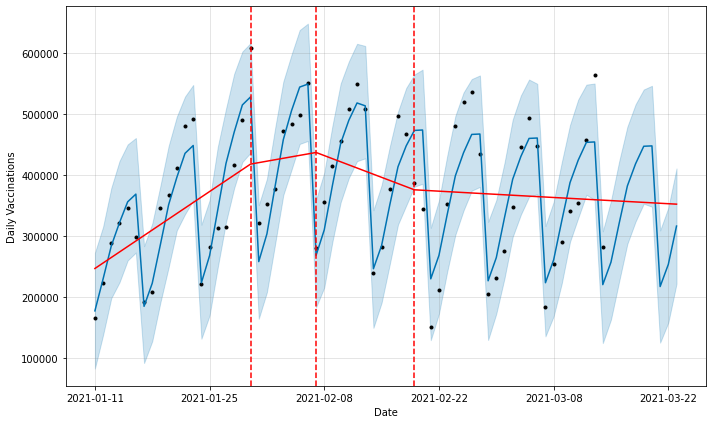

In [37]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

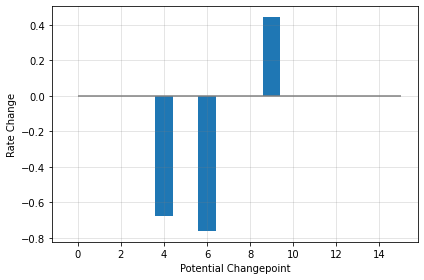

In [38]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

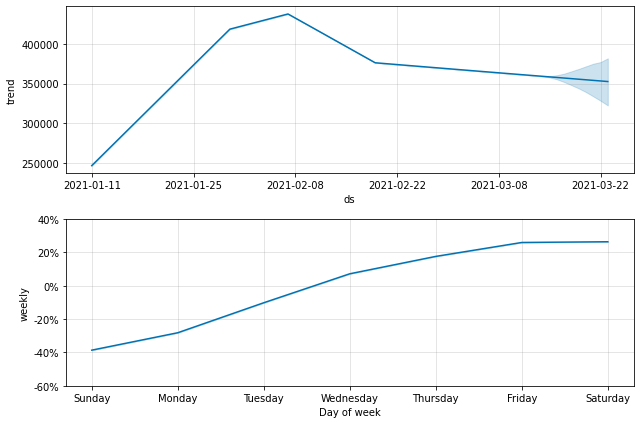

In [39]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

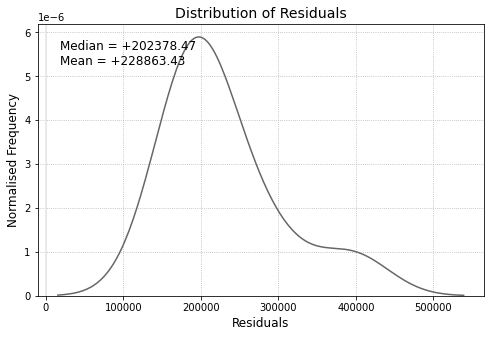

In [40]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

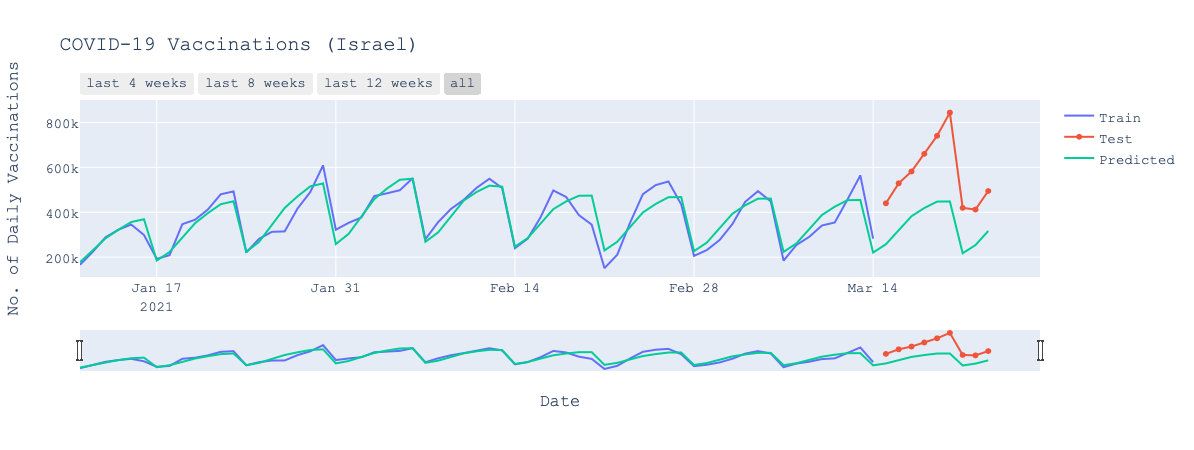

In [41]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (Israel)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

![](./images/nb9_fig3.png)

In [42]:
#Evaluation metrics for FBProphet model
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for FBProphet model for Israel are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for FBProphet model for Israel are:
MAE score: 228863.43
RMSE score: 239277.67
MAPE score: 0.4


***

### 2.2 FB Prophet Model (additional regressors)

In this section we will investigate additing additional regressors to improve the performance of the model. We will start by looking at the effect of Tweet sentiments on the prediction of daily vaccinations for Israel.

#### **TASK 1**: Daily Vaccinations (raw) (Israel)

1) Load Twitter sentiment data and combine with Israel vaccination data

2) Create new features for positive, negative and neutral sentiment counts (worldwide) with a lag of 3 days

3) Split data into train and test

4) Train model (for now with identical hyperparameters to the above model) and predict

5) Visualise results

6) Evaluation metrics


**KEY FINDINGS**

Adding additional regressors does improve the model from 40% to 36% MAPE and requires a more detailed investigation.

In [43]:
#Load and process Tweet sentiment analysis (no. of pos., neg. and neutral Tweets per day (globally))
df_tweets = pd.read_csv('data/global_vacc_senti.csv', parse_dates=['date'])
df_tweets.sort_values('date', inplace=True)
df_tweets = df_tweets.set_index('date')
df_tweets = df_tweets[['negative', 'neutral', 'positive']]
df_tweets.fillna(0, inplace=True)

In [44]:
#Create new lag 3 features for Tweets sentiment analyses
df_tweets['lag_3_neg'] = df_tweets['negative'].shift(3)
df_tweets['lag_3_neu'] = df_tweets['neutral'].shift(3)
df_tweets['lag_3_pos'] = df_tweets['positive'].shift(3)

#Merge Twitter dataframe with vaccination progress dataframe
df_tweets_isr = pd.merge(df_isr, df_tweets, on='date')

#Drop any rows that contain zeros or are empty at the beginning of the series (i.e. in train)
df_tweets_isr.replace([0], np.nan, inplace=True)
df_tweets_isr.dropna(inplace=True, how='any')

In [45]:
#Split data into train and test set
df_train, df_test = df_tweets_isr[:'2021-03-14'].reset_index(), df_tweets_isr['2021-03-15':].reset_index()

#Check the number of records in train and test
print(df_train.shape, df_test.shape)

(44, 8) (9, 8)


In [46]:
#Set date as index
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

#Reset index
df_train = df_train.reset_index()
df_test = df_test.reset_index()

#Relabel columns for forecasting
df_train_fbp = df_train.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)
df_test_fbp = df_test.rename({'date': 'ds', 'daily_vaccinations_raw_israel': 'y'}, axis=1)

In [47]:
#Forecasting with FB Prophet
#Define and fit model
model = Prophet(growth='linear', #Not logistic as limit would be 2 x world/country population and way above what would ever be achiebed
                n_changepoints=15,
                changepoint_range=0.95, #Set to 90% of training data as only few datapoints available
                changepoint_prior_scale=0.5, #useful hyperparameter to tune in case of underfitting
                seasonality_mode='multiplicative', #Set to multiplicative to account for increasing seasonality effect over time
                seasonality_prior_scale=30, #useful hyperparameter to tune in case of underfitting
                interval_width=0.95,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality = False)

#Add Twitter sentiment regressors
model.add_regressor('lag_3_pos', standardize='False') #Additive is default, can also add mode='multiplicative'
model.add_regressor('lag_3_neg', standardize='False') #Additive is default
model.add_regressor('lag_3_neu', standardize='False') #Additive is default

#Fit model
model.fit(df_train_fbp)

#Create future dataframe for next 10 days
future = model.make_future_dataframe(periods=9) #Default frequency: daily

#Add additional features to future dataframe
future['lag_3_pos'] = df_tweets_isr.reset_index().lag_3_pos
future['lag_3_neg'] = df_tweets_isr.reset_index().lag_3_neg
future['lag_3_neu'] = df_tweets_isr.reset_index().lag_3_neu

#Predict future dataframe
forecast=model.predict(future)

In [48]:
#Create dataframe of train/test and forecasted data
data = pd.concat([df_train_fbp,df_test_fbp])
verify = pd.merge(forecast, data, on='ds')

#Check original data versus forecast incl. ci
verify[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').tail(10)

y           yhat     yhat_lower     yhat_upper
ds                                                               
2021-03-14  282381.0  218203.479867  136284.582656  302987.892388
2021-03-15  440051.0  208365.377344  118926.460225  299737.017284
2021-03-16  529119.0  345779.422494  264190.959575  431827.482344
2021-03-17  581855.0  406412.456212  322837.485278  489012.354567
2021-03-18  660276.0  484067.736055  400814.907383  571474.378503
2021-03-19  740655.0  459246.767033  375488.828881  543442.118156
2021-03-20  844285.0  431919.552035  338148.359980  525538.381624
2021-03-21  419618.0  244257.692954  163692.672727  329014.862975
2021-03-22  412197.0  266088.493864  187643.898337  354143.638146
2021-03-23  494805.0  427528.664441  337157.610398  525547.143542

In [49]:
#Correlation
print(verify.loc['2021-03-15':,['y','yhat']].corr())

             y      yhat
y     1.000000  0.699974
yhat  0.699974  1.000000


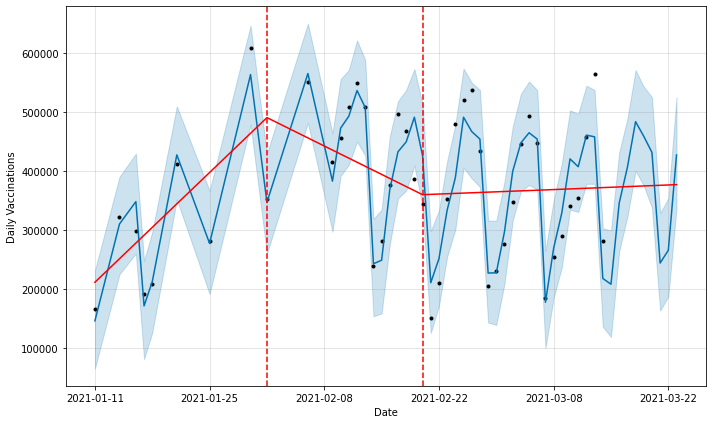

In [50]:
#Plot model
fig1 = model.plot(forecast, xlabel='Date', ylabel='Daily Vaccinations')
a = add_changepoints_to_plot(fig1.gca(),model,forecast) #optional or via fig2
fig1.set_figwidth(10)

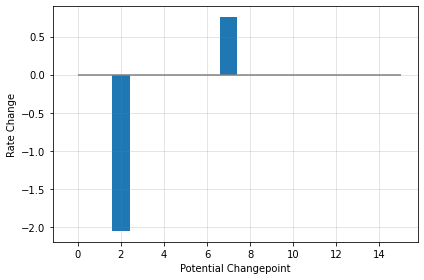

In [51]:
#Analyse potential changepoints
deltas = model.params['delta'].mean(0)

fig2 = plt.figure(facecolor='w')
ax = fig2.add_subplot(111)

ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate Change')
ax.set_xlabel('Potential Changepoint')
ax.hlines(y=0, xmin=0, xmax=15, color='grey')

fig2.tight_layout();

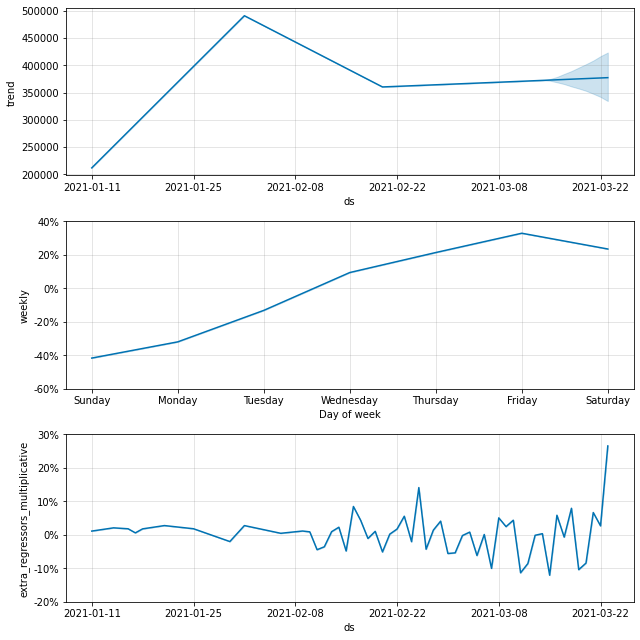

In [52]:
#Plot model components (in this case trend and weekly)
fig3 = model.plot_components(forecast)

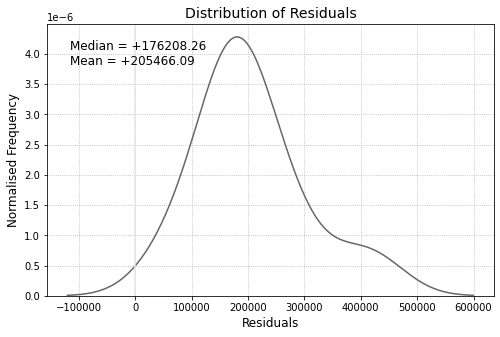

In [53]:
#Check distribution of residuals
#Calculate residuals
residuals=(verify.query('ds>="2021-03-15"')['y']) - (verify.query('ds>="2021-03-15"')['yhat'])

#Density plot
fig4, ax = plt.subplots(figsize=(8,5))

sns.kdeplot(residuals, ax=ax, color='0.4')

ax.grid(ls=':')
ax.set_xlabel('Residuals', fontsize=12)
ax.set_ylabel('Normalised Frequency', fontsize=12)
ax.axvline(0, color='0.9')
ax.set_title('Distribution of Residuals', fontsize=14)
ax.text(0.05, 0.85, 'Median = {:+1.2f} \nMean = {:+4.2f}'.format(
                                                                residuals.median(),
                                                                residuals.mean()),
                                                                fontsize=12,
                                                                transform=ax.transAxes);

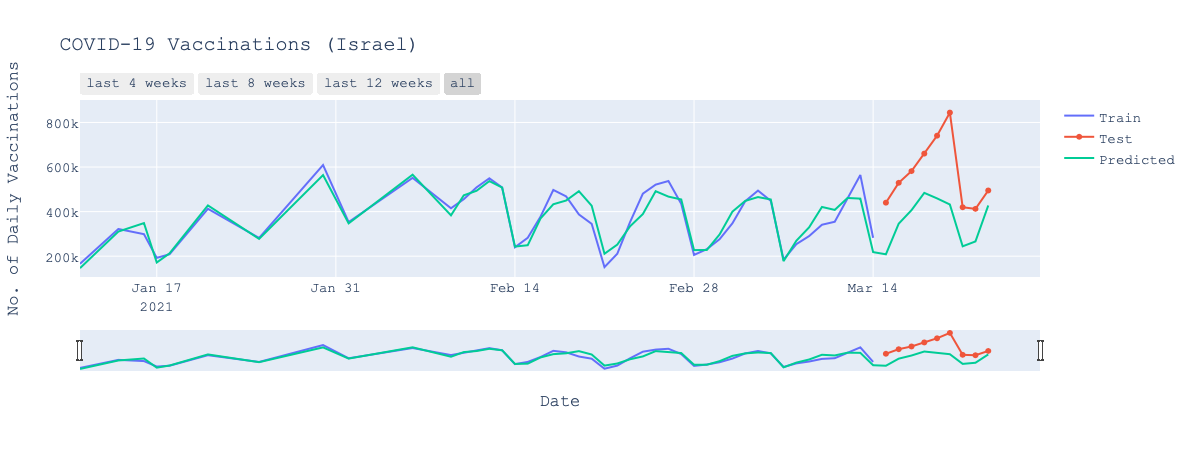

In [54]:
#Create Plotly plot of traces for original and predicted values
fig5 = go.Figure()

#Define traces for train/test and forecast
fig5.add_trace(go.Scatter(x=verify.query('ds<"2021-03-15"')['ds'], y=verify.query('ds<"2021-03-15"')['y'], name='Train'))
fig5.add_trace(go.Scatter(x=verify.query('ds>="2021-03-15"')['ds'], y=verify.query('ds>="2021-03-15"')['y'], name='Test'))
fig5.add_trace(go.Scatter(x=verify.ds, y=verify.yhat, name='Predicted'))

#Define range slider and time-span buttons
fig5.update_xaxes(
                rangeslider_visible=True,
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label='last 4 weeks', step='month', stepmode='backward'),
                        dict(count=2, label='last 8 weeks', step='month', stepmode='backward'),
                        dict(count=3, label='last 12 weeks', step='month', stepmode='backward'),
                        dict(step='all')
                        
                    ])
                )
)

#Define title and axis labels
fig5.update_layout(
    title="COVID-19 Vaccinations (Israel)",
    xaxis_title='Date',
    yaxis_title='No. of Daily Vaccinations',
    font=dict(
        family='Courier New, monospace',
        size=14,
    )
)

fig5.show();

![](./images/nb9_fig4.png)

In [55]:
#Evaluation metrics for FBProphet model
mae = mean_absolute_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])
rmse = mean_squared_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'], squared=False)
mape = mean_absolute_percentage_error(verify.query('ds>="2021-03-15"')['y'],  verify.query('ds>="2021-03-15"')['yhat'])

print('====='*10)
print(f'The metrics for the FBProphet model for Israel are:')
print('====='*10)
print(f'MAE score: {round(mae,2)}')
print(f'RMSE score: {round(rmse,2)}')
print(f'MAPE score: {round(mape,2)}')
print('====='*10)

The metrics for the FBProphet model for Israel are:
MAE score: 205466.09
RMSE score: 224841.17
MAPE score: 0.36


***
***

## 3. SUMMARY

***

### 3.1 Key Findings

The FBprophet model so far performs as well for the worldwide daily vaccination predictions as the Holt-Winters model, but offers no advantage. With respect to Germany and Israel thus far FBProphet performs significantly worse as compared to Holt-Winters. It should be noted that hyperparameter tuning has not been performed for these two countries as yet, but a significant improvement is not expected. Adding additional regressors was initiated with worldwide Tweet sentiments at lag-3 being incorporated into the prediction for Israel, a country where the difference between HW and FBP was most significant, and an improvement from 40% to 36% MAPE could be seen. 

***

### 3.2 Next Steps

As next steps we would perform grid searches and cross validations for the above countries on a newer dataset and also include additonal countries, such as UK, USA and India. More importantly we would initiate a detailed investigation into additonal regressores, most noteworthy including the weekdays as a categorical feature, as well as different lags for the Twitter sentiments (i.e. lags 7, 10, 14, 21) and lag values from worldwide and specific countries vaccination progress (i.e. lags 2/3, 7, 10, 14, 21). It will be very interesting to see if we can improve predictions by including lag values from other countries that are most influential globally with repect to the COVID-19 vaccination progress. moreover, as most of the Twitter sentiment information pertains to India (and China) and a substantial, most imfluencial subset of these from Government/news sources, it will be interesting to see how much a Twitter sentiment regeressor could improve a prediction of daily vaccinations for India. Before we venture into this however, we should perform Granger causality tests. And, last but not least we should bare in mind that Twitter activity is somewhat endogeneous with respect to vaccination progress with with Tweets being linked in eithera pre- and post-event manner (but this not being distinguishable).

***